In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
## Stock Symbols contains list of 1250 NSE stock symbols (Need to update it every quarter / year)

stock_data = pd.read_csv('stock_data.csv')
stock_data.set_index('SYMBOL', inplace=True)
len(stock_data)

1435

In [3]:
monthly_return_volume = pd.DataFrame({'SYMBOL':[], 'SECTOR':[], 'INDUSTRY':[], 'MARKET_CAP':[], 'JAN':[], 'FEB':[], 'MAR':[], 'APR':[],  
                                'MAY':[], 'JUN':[], 'JUL':[], 'AUG':[], 'SEP': [], 'OCT':[], 'NOV':[], 'DEC': []})

for symbol in stock_data.index.values:
    try:
        stock = yf.download(symbol + ".NS", start=(pd.to_datetime('today') - pd.DateOffset(days=330)), end=pd.to_datetime('today') + pd.DateOffset(days=1), progress=False)
        
        #start_date = '2022-07-01'
        #end_date = '2023-06-30'
        #stock = yf.download(symbol + ".NS", start=start_date, end=end_date, progress=False)
        
        stock_length = len(stock['Close'])
        
        if stock_length > 200:
            total_volume = stock['Volume'].sum()
            stock['Month'] = stock.index.strftime("%b")
            grouped_by_month = stock.groupby('Month')
            
            monthly_return_data = {'SYMBOL': [symbol], 
                                   'SECTOR': [stock_data.loc[symbol]['SECTOR']],
                                   'INDUSTRY': [stock_data.loc[symbol]['INDUSTRY']],
                                   'MARKET_CAP': [stock_data.loc[symbol]['Mar Cap Rs.Cr.']],
                                   'JAN': 0, 'FEB': 0, 'MAR': 0, 'APR': 0, 'MAY': 0,
                                   'JUN': 0, 'JUL': 0, 'AUG': 0, 'SEP': 0, 'OCT': 0,
                                   'NOV': 0, 'DEC': 0}
            
            monthly_volume_data = {'SYMBOL': [''], 
                                   'SECTOR': [stock_data.loc[symbol]['SECTOR']],
                                   'INDUSTRY': [stock_data.loc[symbol]['INDUSTRY']],
                                   'MARKET_CAP': [stock_data.loc[symbol]['MARKET_CAP']],
                                   'JAN': 0, 'FEB': 0, 'MAR': 0, 'APR': 0, 'MAY': 0,
                                   'JUN': 0, 'JUL': 0, 'AUG': 0, 'SEP': 0, 'OCT': 0,
                                   'NOV': 0, 'DEC': 0}
            
            for month, group in grouped_by_month:
                month_returns = (group.iloc[-1]['Close'] / group.iloc[0]['Close']) - 1
                monthly_return_data[month.upper()] = int(round(month_returns, 2) * 100)
                month_volume = (group['Volume'].sum() * 20) / (total_volume * group.shape[0])
                sign = 1 if month_returns > 0 else -1
                monthly_volume_data[month.upper()] = round((month_volume) * 100 * sign)
            
            cutoff = 15
            
            # Remove this condition to run for all stocks 
            if(monthly_volume_data['APR'] >= cutoff or monthly_return_data['APR'] >= cutoff or monthly_volume_data['MAR'] >= cutoff or monthly_return_data['MAR'] >= cutoff):
                monthly_return_volume = pd.concat([monthly_return_volume, pd.DataFrame(monthly_return_data)], ignore_index=True)
                monthly_return_volume = pd.concat([monthly_return_volume, pd.DataFrame(monthly_volume_data)], ignore_index=True)
                
    except Exception as e:
        print(f"An error occurred: {symbol}, {str(e)}")

print(f"Execution completed.")

Execution completed.


In [4]:
monthly_return_volume_filtered = monthly_return_volume[monthly_return_volume['MARKET_CAP'] > 500]

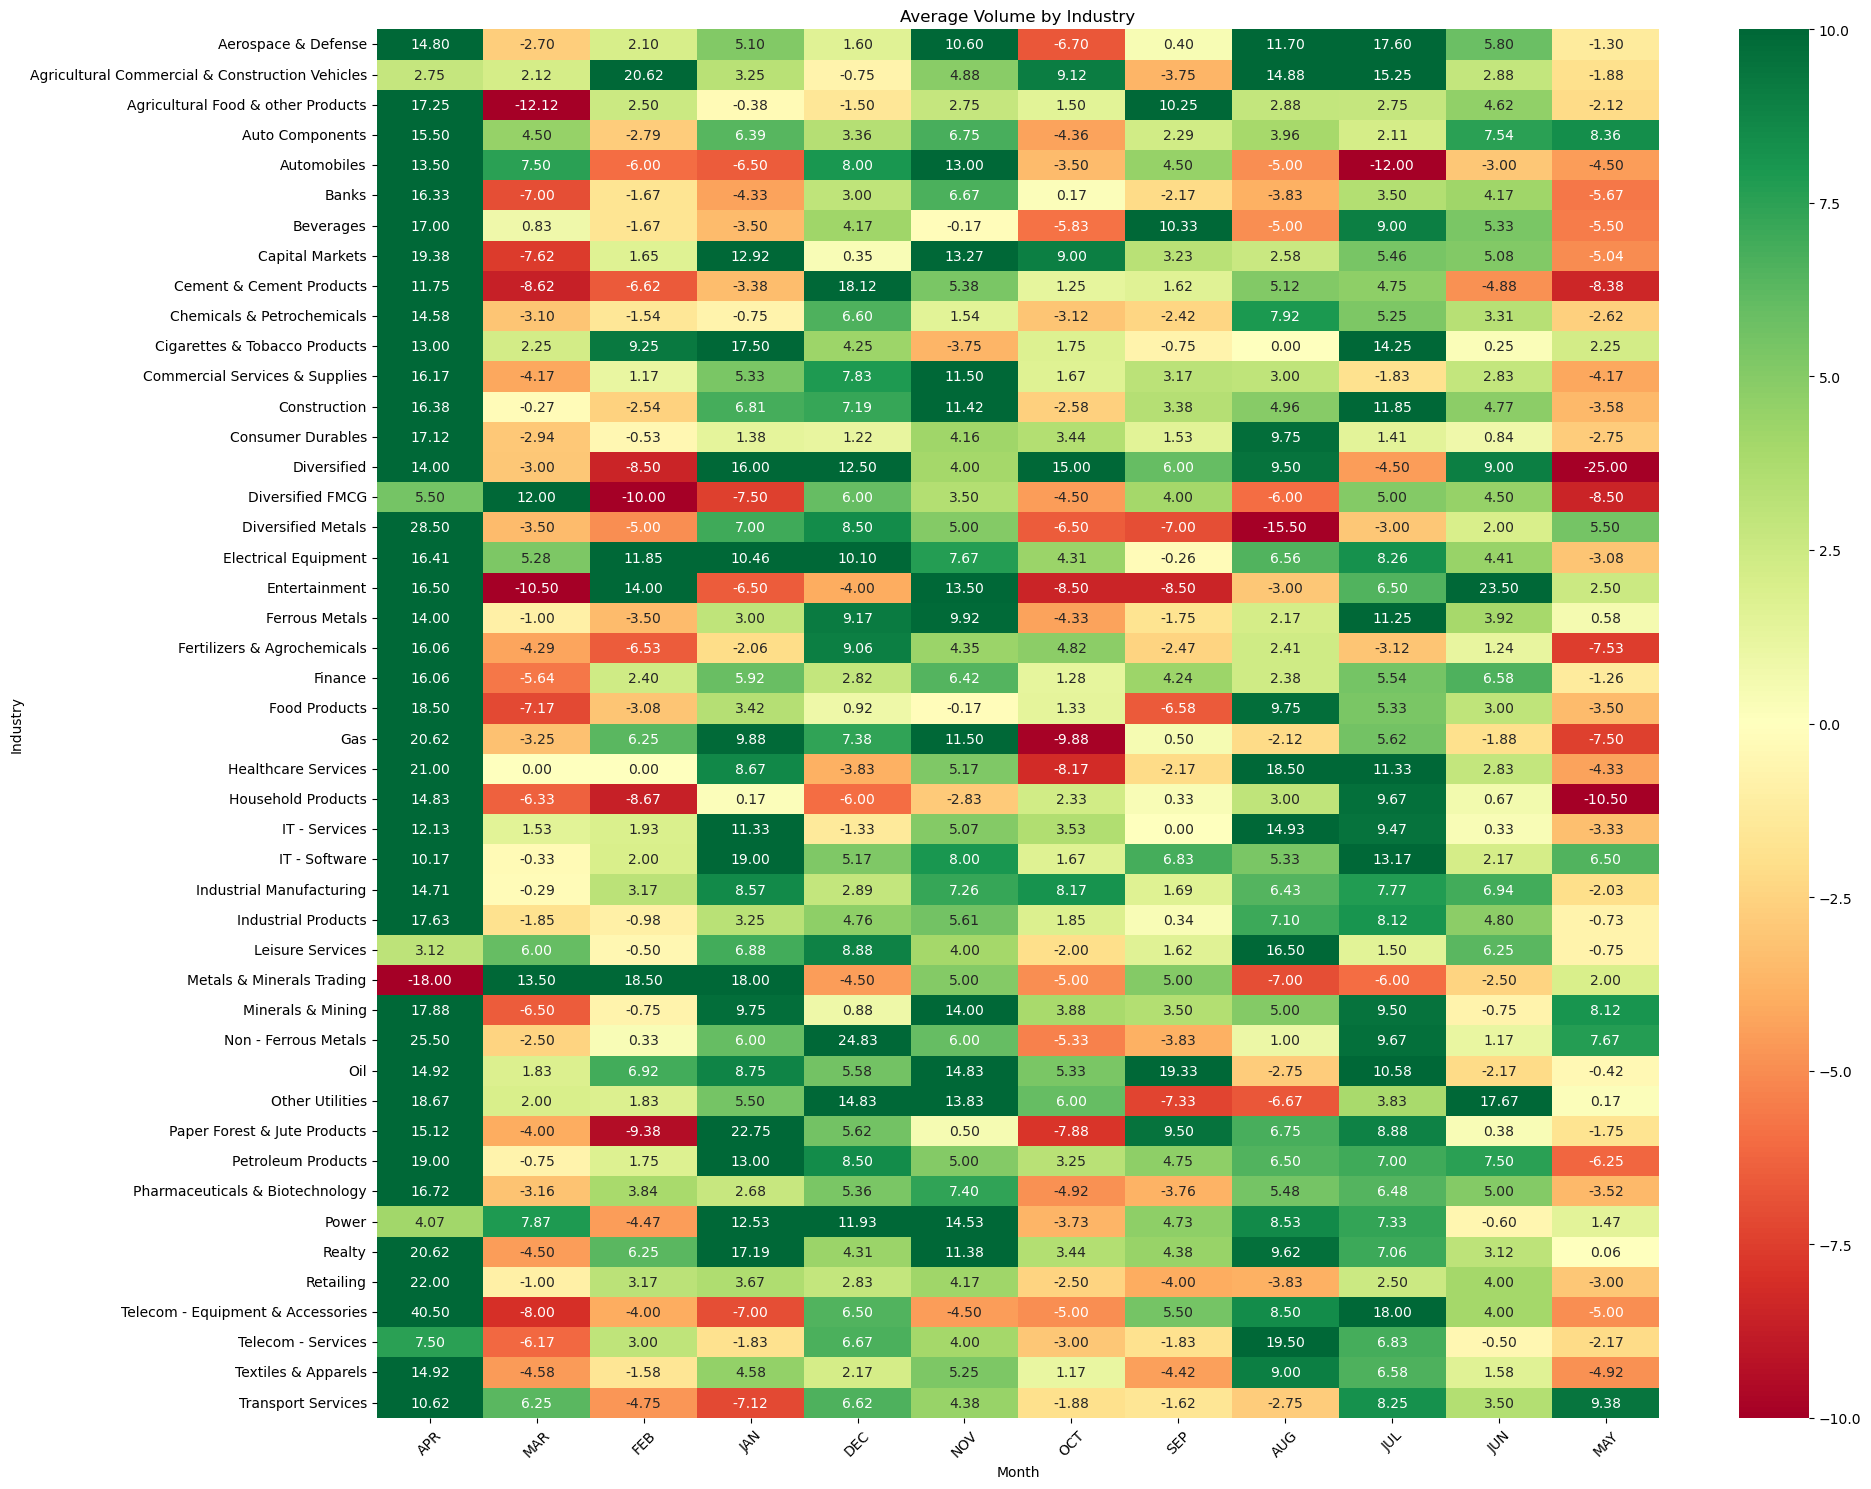

In [5]:
months = ['APR', 'MAR', 'FEB', 'JAN', 'DEC', 'NOV', 'OCT', 'SEP', 'AUG', 'JUL', 'JUN', 'MAY']
average_volume_by_industry = monthly_return_volume_filtered.groupby('INDUSTRY')[months].mean().round(2)

plt.figure(figsize=(20, 15))
sns.heatmap(average_volume_by_industry, cmap='RdYlGn', annot=True, fmt=".2f", vmin=-10, vmax=10)
plt.title('Average Volume by Industry')
plt.xlabel('Month')
plt.ylabel('Industry')
plt.xticks(rotation=45)
plt.tight_layout()

# Save to PDF
plt.savefig('heatmap.pdf', format='pdf')
plt.show()

In [6]:
# Create a PDF file to save the plots
pdf_pages = PdfPages('industry_stocks_volume_heatmaps.pdf')
months_order = ['APR', 'MAR', 'FEB', 'JAN', 'DEC', 'NOV', 'OCT', 'SEP', 'AUG', 'JUL', 'JUN', 'MAY']
#months_order = ['JUN', 'MAY', 'APR', 'MAR', 'FEB', 'JAN', 'DEC', 'NOV', 'OCT', 'SEP', 'AUG', 'JUL']

industry_groups = monthly_return_volume_filtered.groupby('INDUSTRY')

for industry, group in industry_groups:
    industry_stocks = group[['SYMBOL', 'SECTOR', 'INDUSTRY', 'MARKET_CAP'] + months_order]
    industry_stocks_heatmap = industry_stocks.set_index('SYMBOL')
    industry_stocks_heatmap = industry_stocks_heatmap.drop(columns=['SECTOR', 'INDUSTRY', 'MARKET_CAP'])
    industry_stocks_heatmap = industry_stocks_heatmap.apply(pd.to_numeric, errors='coerce')
    
    # Plot heatmap
    plt.figure(figsize=(14, 3 + (3 * (group.shape[0] // 10)))) 
    sns.heatmap(industry_stocks_heatmap, annot=True, cmap="RdYlGn", fmt=".2f", vmin=-15, vmax=15)
    plt.title('Industry Stocks Returns Heatmap - ' + industry)
    plt.xlabel('Months')
    plt.ylabel('Stocks')
    
    # Save the plot to the PDF file
    pdf_pages.savefig()
    plt.close()

# Close the PDF file
pdf_pages.close()

In [7]:
all_symbols = []

for industry, group in industry_groups:
    industry_stocks = group[['SYMBOL', 'SECTOR', 'INDUSTRY', 'MARKET_CAP'] + months_order]
    all_symbols.extend(industry_stocks['SYMBOL'].tolist())

all_symbols = [symbol for symbol in all_symbols if symbol]
all_symbols = list(all_symbols)

print(all_symbols)

['HAL', 'DATAPATTNS', 'GRSE', 'ZENTEC', 'ROSSELLIND', 'ESCORTS', 'ACE', 'SANGHVIMOV', 'SMLISUZU', 'KSCL', 'ATFL', 'GULPOLY', 'MAGADSUGAR', 'SCHAEFFLER', 'EXIDEIND', 'SUNDRMFAST', 'SHRIPISTON', 'JAMNAAUTO', 'SHARDAMOTR', 'RICOAUTO', 'IGARASHI', 'HITECHGEAR', 'STERTOOLS', 'RML', 'ASAL', 'PAVNAIND', 'RBL', 'EICHERMOT', 'AUBANK', 'CUB', 'SURYODAY', 'UBL', 'SDBL', 'GMBREW', 'NAM-INDIA', 'MOTILALOFS', 'ISEC', 'CDSL', 'MCX', 'CAMS', 'ABSLAMC', 'KFINTECH', 'PRUDENT', 'GEOJITFSL', 'SMCGLOBAL', 'DOLATALGO', 'BIRLAMONEY', 'NUVOCO', 'MANGLMCEM', 'EVERESTIND', 'ACL', 'SOLARINDS', 'LINDEINDIA', 'TATACHEM', 'ATUL', 'VINATIORGA', 'HSCL', 'ALKYLAMINE', 'JUBLINGREA', 'DEEPAKFERT', 'SUDARSCHEM', 'PRIVISCL', 'NEOGEN', 'VIDHIING', 'FOSECOIND', 'CAMLINFINE', 'REFEX', 'PREMEXPLN', 'IGPL', 'MANALIPETC', 'UNIENTER', 'EXCELINDUS', 'CHEMFAB', 'INDOAMIN', 'DMCC', 'OCCL', 'BHAGERIA', 'GODFRYPHLP', 'VSTIND', 'QUESS', 'TEAMLEASE', 'SBC', 'KPIL', 'GRINFRA', 'SWSOLAR', 'ENGINERSIN', 'TECHNOE', 'ISGEC', 'HGINFRA', 'WEL

In [8]:
def download_stock_data(symbol):
    return yf.download(symbol + ".NS", start=pd.to_datetime('today') - pd.DateOffset(365),
                       end=pd.to_datetime('today') + pd.DateOffset(1), progress=False)

def calculate_technical_indicators(data):
    data['5DMA'] = data['Close'].rolling(window=5).mean()
    data['20DMA'] = data['Close'].rolling(window=20).mean()
    data['50DMA'] = data['Close'].rolling(window=50).mean()
    data['100DMA'] = data['Close'].rolling(window=100).mean()
    data['diff'] = data['Close'] - data['Open']
    data['color'] = data['diff'].apply(lambda x: 'green' if x >= 0 else 'red')
    return data

def plot_stock_data(symbol, data):
    # Prepare plot data
    plot_data = data[data.index > (pd.to_datetime('today') - pd.DateOffset(days=180))]

    # Setup subplot layout
    figure = make_subplots(rows=1, cols=2, column_widths=[0.7, 0.3],
                           specs=[[{"secondary_y": True}, {"type": "table"}]])

    # Plot candlestick chart
    figure.add_trace(go.Candlestick(x=plot_data.index,
                                    open=plot_data['Open'],
                                    high=plot_data['High'],
                                    low=plot_data['Low'],
                                    close=plot_data['Close'],
                                    name='Price'), row=1, col=1)

    # Adjust Y-axis and layout for stock prices
    figure.update_yaxes(range=[plot_data['Close'].min()*0.9, plot_data['Close'].max()*1.05], row=1, col=1)
    figure.update_xaxes(rangebreaks=[dict(bounds=['sat', 'mon'])], row=1, col=1)  # hide weekends
    figure.update_layout(title={'text': symbol, 'x': 0.5}, xaxis_rangeslider_visible=False)

    # Plot moving averages and volume
    for ma, color in zip(['5DMA', '20DMA', '50DMA', '100DMA'], ['yellow', 'blue', 'orange', 'green']):
        figure.add_trace(go.Scatter(x=plot_data.index, y=plot_data[ma], marker_color=color, name=f'{ma}'), row=1, col=1)
    figure.add_trace(go.Bar(x=plot_data.index, y=plot_data['Volume'], name='Volume',
                            marker={'color': plot_data['color']}), secondary_y=True, row=1, col=1)
    

    # Hide the secondary Y-axis (volume)
    figure.update_yaxes(range=[0, plot_data['Volume'].max()*5], secondary_y=True, row=1, col=1)
    figure.update_yaxes(visible=False, secondary_y=True, row=1, col=1)

    # Adjust figure size
    #figure.update_layout(height=800, width=1500)

    # Plot stock characteristics in a table
    characteristics = calculate_stock_characteristics(symbol)
    table_trace = go.Table(
                header=dict(values=['Attribute', 'Values'],
                            fill_color='paleturquoise',
                            align='left'),
                cells=dict(values=[list(characteristics.transpose().index), list(characteristics.transpose().values)],
                           fill_color='lavender',
                           align='left'))
    figure.add_trace(table_trace, row=1, col=2)
    return figure

def calculate_stock_characteristics(symbol):
    stock_row = stock_data.loc[symbol]
    characteristics = pd.DataFrame({
                "Attribute": ["INDUSTRY", "SECTOR", "MARKET_CAP", "FNO", "P/E", "QoQ-SALES", "QoQ-PROFIT", "YoY-SALES", "YoY-PROFIT", "PROMOTER", "DII", "FII", "CHANGE-PROMOTER", "EXP-SALES-GROWTH", "RSI", "MACD", "ROCE"],
                "Value": [stock_row['INDUSTRY'], stock_row['SECTOR'], stock_row['Mar Cap Rs.Cr.'], stock_row['FNO'], stock_row['P/E'], stock_row['QoQ Sales %'], stock_row['QoQ Profits %'], stock_row['Qtr Sales Var %'], stock_row['Qtr Profit Var %'], stock_row['Prom. Hold. %'], stock_row['DII Hold %'], stock_row['FII Hold %'], stock_row['Change in Prom Hold %'], stock_row['Exp Qtr Sales Var %'], stock_row['RSI Rs.'], stock_row['MACD Signal Rs.'], stock_row['ROCE']]
            }).set_index("Attribute").T
    return characteristics


def process_stocks(all_symbols):
    num_processed = 0
    file_count = 1
    while num_processed < len(all_symbols):
        figure_html = open(f'momentum_stocks_{file_count}.html', 'w')
        for symbol in all_symbols[num_processed:num_processed+100]:
            try:
                data = download_stock_data(symbol)
                data = calculate_technical_indicators(data)
                figure = plot_stock_data(symbol, data)
                figure_html.write(figure.to_html(full_html=False))
            except Exception as e:
                print(f"Error processing symbol {symbol}: {e}")
        figure_html.close()
        num_processed += 100
        file_count += 1


if __name__ == "__main__":
    symbols = all_symbols
    process_stocks(symbols)
    print('Execution Completed!!!!')

Execution Completed!!!!
